In [1]:
import os
import pandas as pd
import cv2
import math
from tqdm import tqdm
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def image_resize(image, width = None, height = None, inter = cv2.INTER_AREA):
    # initialize the dimensions of the image to be resized and
    # grab the image size
    dim = None
    (h, w) = image.shape[:2]

    # if both the width and height are None, then return the
    # original image
    if width is None and height is None:
        return image

    # check to see if the width is None
    if width is None:
        # calculate the ratio of the height and construct the
        # dimensions
        r = height / float(h)
        dim = (int(w * r), height)

    # otherwise, the height is None
    else:
        # calculate the ratio of the width and construct the
        # dimensions
        r = width / float(w)
        dim = (width, int(h * r))

    # resize the image
    resized = cv2.resize(image, dim, interpolation = inter)

    # return the resized image
    return resized

In [188]:
def preprocess_images_from_folder(folder, subfolder): 
    images = []
    for filename in tqdm(os.listdir(os.path.join(folder, subfolder))):
        img = cv2.imread(os.path.join(os.path.join(folder, subfolder), filename))
        if img is not None: 
            
            # 1. Dilate the image, to get rid of the text
            dilated_img = cv2.dilate(img, np.ones((32,32), np.uint8))
            
            # 2. Median blur the result with a decent sized kernel to further suppress any text.
            bg_img = cv2.medianBlur(dilated_img, 23)

            # 3. Calculate the difference between the original and the background we just obtained. The bits that are identical will be black (close to 0 difference), the text will be white (large difference).
            diff_img = 255 - cv2.absdiff(img, bg_img)

            # 4. Normalize the image, so that we use the full dynamic range.
            norm_img = diff_img.copy() # Needed for 3.x compatibility
            end_one_img = cv2.normalize(diff_img, norm_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)

            # 5. Truncate the remaining gray away and re-normalize the image
            _, thr_img = cv2.threshold(norm_img, 255, 0, cv2.THRESH_TRUNC)
            end_img = cv2.normalize(thr_img, thr_img, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
            
            resized = image_resize(end_img, width=1024)
            
            new_image = np.zeros(resized.shape, resized.dtype)
            alpha = 1.0 # Simple contrast control
            beta = 5    # Simple brightness control

            new_image = cv2.convertScaleAbs(resized, alpha=alpha, beta=beta)
            
            colorized_img = cv2.cvtColor(new_image, cv2.COLOR_BGR2RGB)
            
            result = cv2.imwrite('../processed_data/fyne/' + subfolder + '/' + filename, colorized_img)

folder = '../data/T_Book_Recipes_fyne_W25-W35_Part1/'
subfolders = [dI for dI in os.listdir(folder) if os.path.isdir(os.path.join(folder,dI))]

for subfolder in subfolders:  
    images = preprocess_images_from_folder(folder, subfolder)

100%|██████████| 131/131 [03:11<00:00,  1.46s/it]


## Experiments - Ignore

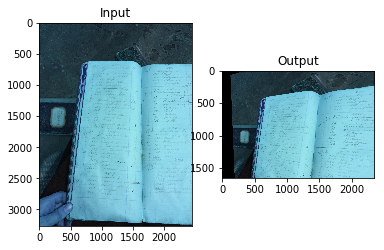

In [177]:
import cv2
import math
import numpy as np
import matplotlib.pyplot as plt

img = cv2.imread('../data/T_Book_Recipes_fyne_W25-W35_Part1/Book_W29_4545-5634_Fyne waterverven_All/IMG_1306.JPG')
rows,cols,ch = img.shape

pts1 = np.float32([[360,50],[2122,470],[2264, 1616],[328,1820]])

ratio=1.6
cardH=math.sqrt((pts1[2][0]-pts1[1][0])*(pts1[2][0]-pts1[1][0])+(pts1[2][1]-pts1[1][1])*(pts1[2][1]-pts1[1][1]))
cardW=ratio*cardH;
pts2 = np.float32([[pts1[0][0],pts1[0][1]], [pts1[0][0]+cardW, pts1[0][1]], [pts1[0][0]+cardW, pts1[0][1]+cardH], [pts1[0][0], pts1[0][1]+cardH]])

M = cv2.getPerspectiveTransform(pts1,pts2)

offsetSize=500
transformed = np.zeros((int(cardW+offsetSize), int(cardH+offsetSize)), dtype=np.uint8);
dst = cv2.warpPerspective(img, M, transformed.shape)

plt.subplot(121),plt.imshow(img),plt.title('Input')
plt.subplot(122),plt.imshow(dst),plt.title('Output')
plt.show()

(3264, 2448, 3)
STEP 1: Edge Detection


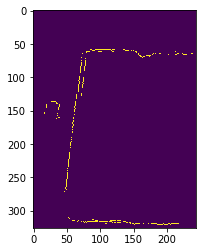

STEP 2: Finding Boundary
STEP 2: Finding Boundary


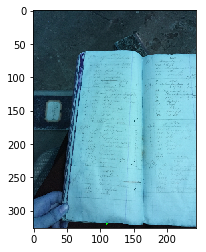

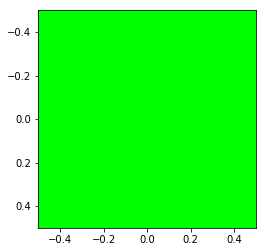

In [180]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
image = cv2.imread('../data/T_Book_Recipes_fyne_W25-W35_Part1/Book_W29_4545-5634_Fyne waterverven_All/IMG_1306.JPG')
print(image.shape)
ori = image.copy()
image = cv2.resize(image, (image.shape[1]//10,image.shape[0]//10))

gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (15,15), 7)
edged = cv2.Canny(gray, 55, 90)
print("STEP 1: Edge Detection")
plt.imshow(edged)
plt.show()
cnts, hierarchy = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
cnts = sorted(cnts[0], key = cv2.contourArea, reverse = True)

# Draw contours
drawing = np.zeros((edged.shape[0], edged.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv.drawContours(drawing, contours, i, color, 2, cv2.LINE_8, hierarchy, 0)
# Show in a window
cv.imshow('Contours', drawing)

for c in cnts:
    ### Approximating the contour
    #Calculates a contour perimeter or a curve length
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.01 * peri, True)
    # if our approximated contour has four points, then we
    # can assume that we have found our screen
    screenCnt = approx
    if len(approx) == 4:
        screenCnt = approx
        break
    # show the contour (outline) 
    print("STEP 2: Finding Boundary")
cv2.drawContours(image, [screenCnt], -1, (0, 255, 0), 2)
image_e = cv2.resize(image,(image.shape[1],image.shape[0]))
# cv2.imwrite('image_edge.jpg',image_e)
plt.imshow(image_e)
plt.show()

# cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
for c in screenCnt:
    x,y,w,h = cv2.boundingRect(c)
    ROI = image[y:y+h, x:x+w]
    break

plt.imshow(ROI)

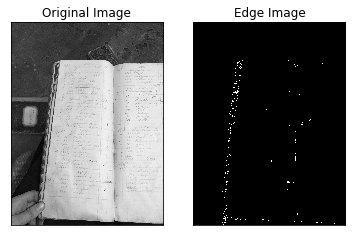

In [47]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
img = cv.imread('../data/T_Book_Recipes_fyne_W25-W35_Part1/Book_W29_4545-5634_Fyne waterverven_All/IMG_1306.JPG',0)
edges = cv.Canny(img,0,450)
plt.subplot(121),plt.imshow(img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()

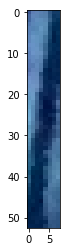

In [53]:
import cv2

image = cv2.imread('../data/T_Book_Recipes_fyne_W25-W35_Part1/Book_W29_4545-5634_Fyne waterverven_All/IMG_1306.JPG')
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray, (7,7), 0)
thresh = cv2.adaptiveThreshold(blur,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,9,12)

cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = cnts[0] if len(cnts) == 2 else cnts[1]
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
for c in cnts:
    x,y,w,h = cv2.boundingRect(c)
    ROI = image[y:y+h, x:x+w]
    break

plt.imshow(ROI)

Original image dimensions: 3264x2448
Execution time: 0.2341160774230957 sec


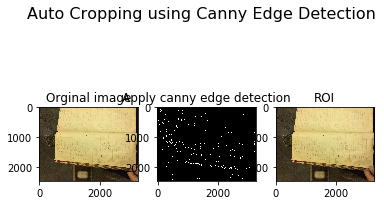

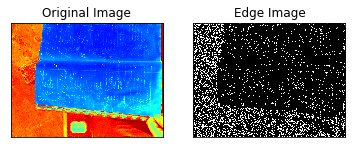

In [84]:
from time import time

import cv2
import matplotlib.pyplot as plt
import numpy as np

def auto_crop(file_name):
    """
    Input argument: file_name (Image file name, e.g., 'rose.tif')
    
    This function will auto crop the given image using image processing technique
    
    Output: ROI
    """
    # Start timer
    start_time = time()
    # Read an image
    img = cv2.imread(file_name, cv2.IMREAD_UNCHANGED)
    height = img.shape[0]
    width = img.shape[1]
    # Check image is grayscale or not 
    if len(img.shape) == 2:
        gray_img = img.copy()
    else:
        # Convert bgr image to grayscale image
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # To find upper threshold, we need to apply Otsu's thresholding
    upper_thresh, thresh_img = cv2.threshold(gray_img, thresh=0, maxval=255, type=cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    # Calculate lower threshold
    lower_thresh = 0.5*upper_thresh
    # Apply canny edge detection
    canny = cv2.Canny(img, lower_thresh, upper_thresh)
    # Finding the non-zero points of canny
    pts = np.argwhere(canny>0)
    # Finding the min and max points
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    # Crop ROI from the givn image
    roi_img = img[y1:y2, x1:x2]
    # Printing image dimensions, execution time
    print(f'Original image dimensions: {width}x{height}')
    print(f'Execution time: {time()-start_time} sec')
    # Display images
    fig = plt.figure()
    fig.suptitle('Auto Cropping using Canny Edge Detection', fontsize=16)
    fig.add_subplot(1,3, 1).set_title('Orginal image')
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    fig.add_subplot(1,3, 2).set_title('Apply canny edge detection')
    plt.imshow(cv2.cvtColor(canny, cv2.COLOR_BGR2RGB))
    fig.add_subplot(1,3, 3).set_title('ROI')
    plt.imshow(cv2.cvtColor(roi_img, cv2.COLOR_BGR2RGB))
    plt.show()

    return roi_img


def image_attributes(img):
    """
    Input argument: img (Opencv mat)
    
    This function will display the following image attributes:
    - Height and Width
    - Color Channel
    - DPI
    - Max/Min/Average Intensity Values

    Output: image attributes
    """
    height = img.shape[0]
    width = img.shape[1]
    if len(img.shape) == 2:
        no_of_channels = 1
    else:
        no_of_channels = img.shape[2]
    bit_depth = no_of_channels*8
    storage_size = int((height*width*bit_depth)/8)
    # Calculate intensity value
    min_intensity = img.min(axis=0).min(axis=0)
    max_intensity = img.max(axis=0).max(axis=0)
    average_intensity = img.mean(axis=0).mean(axis=0).astype(int)

    print(f'- Image dimensions: {width}x{height}')
    print(f'- Height (rows): {height} pixels')
    print(f'- Width (columns): {width} pixels')
    print(f'- No. of pixels: {height*width}')
    print(f'- Color channels: {no_of_channels}')
    print(f'- Bit depth: {bit_depth}')
    print(f'- Storage size (without compression)): {storage_size} bytes')
    print('- Intensity Values')
    if no_of_channels == 1:
        print(f'\tMin Intensity: {min_intensity}')
        print(f'\tMax Intensity: {max_intensity}')
        print(f'\tAverage Intensity: {average_intensity}')
    elif no_of_channels == 3:
        print(f'\tMin Intensity (Blue): {min_intensity[0]}')
        print(f'\tMax Intensity (Blue): {max_intensity[0]}')
        print(f'\tAverage Intensity (Blue): {average_intensity[0]}')
        print(f'\tMin Intensity (Green): {min_intensity[1]}')
        print(f'\tMax Intensity (Green) {max_intensity[1]}')
        print(f'\tAverage Intensity (Green): {average_intensity[1]}')
        print(f'\tMin Intensity (Red): {min_intensity[2]}')
        print(f'\tMax Intensity (Red) {max_intensity[2]}')
        print(f'\tAverage Intensity (Red): {average_intensity[2]}')


def image_features(img):
    """
    Input argument: img (Opencv mat)
    
    This function will display the following image features:
    - Edges 
    - Corners / interest points
    - Blobs / regions of interest points
    - Ridges

    Output: display image features
    """
    # Apply canny edge detection
    canny_img = cv2.Canny(img, 50, 200)
    # Check image is grayscale or not 
    if len(img.shape) == 2:
        gray_img = img.copy()
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        # Convert bgr image to grayscale image
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Get heatmap image
    heatmap_img = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)

    # Corners detection
    corner_img = img.copy()
    gray_img_float = np.float32(gray_img)
    dst = cv2.cornerHarris(gray_img_float,2,3,0.04)
    dst = cv2.dilate(dst, None)
    # Threshold for an optimal value
    corner_img[dst>0.01*dst.max()]=[0,0,255]

#     ridge_filter = cv2.ximgproc.RidgeDetectionFilter_create()
#     ridges_img = ridge_filter.getRidgeFilteredImage(img)

    # Display image features
    fig = plt.figure()
    fig.suptitle('Image Features', fontsize=16)
    
    fig.add_subplot(2,2, 1).set_title('Edges')
    plt.imshow(cv2.cvtColor(canny_img, cv2.COLOR_BGR2RGB))
    
    fig.add_subplot(2,2, 2).set_title('Corners')
    plt.imshow(cv2.cvtColor(corner_img, cv2.COLOR_BGR2RGB))

#     fig.add_subplot(2,2, 3).set_title('Ridges')
#     plt.imshow(cv2.cvtColor(ridges_img, cv2.COLOR_BGR2RGB))
    
    fig.add_subplot(2,2, 4).set_title('Heatmap')
    plt.imshow(cv2.cvtColor(heatmap_img, cv2.COLOR_BGR2RGB))
    plt.show()



# for filename in os.listdir('../data/T_Book_Recipes_fyne_W25-W35_Part1/Book_W29_4545-5634_Fyne waterverven_All/'):
file_name = '../data/T_Book_Recipes_fyne_W25-W35_Part1/Book_W29_4545-5634_Fyne waterverven_All/IMG_1302.JPG'
roi_img = auto_crop(file_name)

# Apply canny edge detection
canny_img = cv2.Canny(roi_img, 50, 200)
# Check image is grayscale or not 
if len(roi_img.shape) == 2:
    gray_img = roi_img.copy()
    img = cv2.cvtColor(roi_img, cv2.COLOR_GRAY2BGR)
else:
    # Convert bgr image to grayscale image
    gray_img = cv2.cvtColor(roi_img, cv2.COLOR_BGR2GRAY)

# Get heatmap image
heatmap_img = cv2.applyColorMap(gray_img, cv2.COLORMAP_JET)

# cv2.imwrite('test.jpg', heatmap_img)
edges = cv.Canny(heatmap_img,0,200)
plt.subplot(121),plt.imshow(heatmap_img,cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(edges,cmap = 'gray')
plt.title('Edge Image'), plt.xticks([]), plt.yticks([])
plt.show()


In [109]:
# roi_img = auto_crop('test.jpg')


img = cv2.imread("test.jpg")

##(2) convert to hsv-space, then split the channels
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
h,s,v = cv2.split(hsv)

##(3) threshold the S channel using adaptive method(`THRESH_OTSU`) or fixed thresh
th, threshed = cv2.threshold(img, 119, 255, cv2.THRESH_BINARY)

##(4) find all the external contours on the threshed S
cnts = cv2.findContours(threshed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)[-2]
canvas  = img.copy()
cv2.drawContours(canvas, cnts, -1, (0,255,0), 1)

## sort and choose the largest contour
cnts = sorted(cnts, key = cv2.contourArea)
cnt = cnts[-1]

## approx the contour, so the get the corner points
arclen = cv2.arcLength(cnt, True)
approx = cv2.approxPolyDP(cnt, 0.02* arclen, True)
cv2.drawContours(canvas, [cnt], -1, (255,0,0), 1, cv2.LINE_AA)
cv2.drawContours(canvas, [approx], -1, (0, 0, 255), 1, cv2.LINE_AA)

plt.imshow(canvas)
plt.imshow(img)
# edged = cv2.Canny(heatmap_img, 75, 60)
# print("STEP 1: Edge Detection")
# plt.imshow(edged)

error: OpenCV(4.5.1) /private/var/folders/nz/vv4_9tw56nv9k3tkvyszvwg80000gn/T/pip-req-build-oe0iat4a/opencv/modules/imgproc/src/contours.cpp:197: error: (-210:Unsupported format or combination of formats) [Start]FindContours supports only CV_8UC1 images when mode != CV_RETR_FLOODFILL otherwise supports CV_32SC1 images only in function 'cvStartFindContours_Impl'


In [162]:
import random as rng

img = cv2.imread("test.jpg")

src_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
src_gray = cv2.blur(src_gray, (3,3))

ret, thresh = cv2.threshold(src_gray,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

# Detect edges using Canny
canny_output = cv2.Canny(thresh, ret, ret * 2)

# Find contours
contours, hierarchy = cv2.findContours(canny_output, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
# Draw contours
drawing = np.zeros((canny_output.shape[0], canny_output.shape[1], 3), dtype=np.uint8)
for i in range(len(contours)):
    color = (rng.randint(0,256), rng.randint(0,256), rng.randint(0,256))
    cv2.drawContours(drawing, contours, i, color, 2, cv2.LINE_8, hierarchy, 0)
# cnts = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
# canvas  = img.copy()
# cv2.drawContours(canvas, cnts, -1, (0,255,0), 1)

In [150]:
ret

119.0

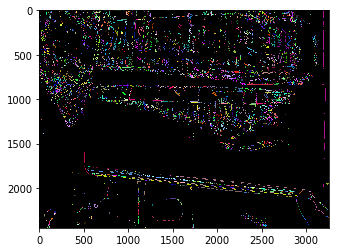

In [163]:
plt.imshow(drawing)